# AbAg_complex Version 1

This notebook generates a dataframe containing information about data first version of the Antibody-Antigen_complexes dataset:

- Overlap of AbDb data (filtered and enriched abag data) with SAbDab data (affinity values for conformtions) 

In [1]:
import os
import pandas as pd
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings("ignore")
from abag_affinity.utils.config import read_config, get_data_paths, get_resources_paths

In [2]:
config = read_config("../../config.yaml")

summary_path, pdb_path = get_resources_paths(config, "SAbDab")
sabdb_summary_df = pd.read_csv(summary_path, sep="\t")
sabdb_summary_df = sabdb_summary_df.set_index("pdb")

abdb_summary_path, abdb_pdb_path = get_resources_paths(config, "AbDb")
abdb_summary_df = pd.read_csv(abdb_summary_path)
abdb_summary_df = abdb_summary_df.set_index("pdb")
abdb_pdb_ids = os.listdir(abdb_pdb_path)
abdb_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in abdb_pdb_ids])

In [3]:
# get overlap using pdb ids
sabdab_pdb_ids = set(sabdb_summary_df.index.unique())
overlapping_ids = abdb_pdb_ids.intersection(sabdab_pdb_ids)

#### Incorporate redundant files

In [4]:
# load information on redundant AbDb files
redunant_file_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["AbDb"]["folder_path"], "Redundant_LH_Protein_Martin.txt")
with open(redunant_file_path) as f:
    lines = f.readlines()
    
redundant_ids = {}
all_ids = set() # all (redundant) PDB ids in AbDb
for line in lines:
    pdb_ids = line.split(",")
    pdb_ids = [pdb_id.strip().lower().split("_")[0] for pdb_id in pdb_ids]
    pdb_ids = [pdb_id for pdb_id in pdb_ids if pdb_id.strip() != ""]
    all_ids.update(pdb_ids)
    for i, pdb_id in enumerate(pdb_ids):
        redundant_ids[pdb_id] = pdb_ids

In [5]:
# remove all PDB ids that are redundant to one of the overlapping PDB Ids
for pdb_id in overlapping_ids:
    for redundant_id in redundant_ids[pdb_id]:
        all_ids.discard(redundant_id)

In [6]:
add_pdbs = set()

remaining_in_sabdab = all_ids.intersection(sabdab_pdb_ids)
while len(remaining_in_sabdab) > 0:
    pdb_id = remaining_in_sabdab.pop()
    add_pdbs.add(pdb_id)
    for redundant_id in redundant_ids[pdb_id]:
        remaining_in_sabdab.discard(redundant_id)

In [7]:
# download extra pdb files from AbDb database
import urllib.request 

download_extra_files = False

if download_extra_files:

    url = "http://www.abybank.org/abdb/Data/LH_Protein_Martin/{}_1.pdb"

    for pdb_id in add_pdbs:
        pdb_id = pdb_id.upper()
        filepath = os.path.join(abdb_pdb_path, pdb_id + "_1.pdb")
        if os.path.exists(filepath):
            print(pdb, "already exists")
            continue
        try:
            urllib.request.urlretrieve(url.format(pdb_id), filepath)
        except:
            print(pdb_id)
        print("Downloaded", pdb_id)

In [8]:
#overlapping_ids.update(add_pdbs)

In [9]:
dataset = sabdb_summary_df[sabdb_summary_df.index.isin(overlapping_ids)].copy()
dataset = dataset.join(abdb_summary_df)

dataset = dataset[["affinity", "delta_g", "affinity_method", "temperature", 'abdb_filename', 'antibody_chains', 'antigen_chains', "Hchain", "Lchain", "antigen_chain"]]

In [11]:
dataset = dataset.drop_duplicates().reset_index()
dataset

,index,pdb,affinity,delta_g,affinity_method,temperature,abdb_filename,antibody_chains,antigen_chains,Hchain,Lchain,antigen_chain
0,0,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],H,L,W
1,1,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],K,J,V
2,2,1bvk,1.400000e-08,-10.530000,Other,20,1BVK_1.pdb,"['L', 'H']",['F'],B,A,C
3,3,1bvk,1.400000e-08,-10.530000,Other,20,1BVK_1.pdb,"['L', 'H']",['F'],E,D,F
4,4,1cz8,1.100000e-10,-14.120000,SPR,37,1CZ8_1.pdb,"['L', 'H']",['W'],Y,X,V
...,...,...,...,...,...,...,...,...,...,...,...,...
725,725,6ii9,1.940000e-08,-10.521321,SPR,NaN,6II9_1.pdb,"['L', 'H']",['C'],P,Q,E
726,726,6ii9,1.940000e-08,-10.521321,SPR,NaN,6II9_1.pdb,"['L', 'H']",['C'],H,L,A
727,727,6mhr,2.200000e-08,-10.446805,SPR,NaN,6MHR_1.pdb,"['L', 'H']","['D', 'F']",A,B,C
728,728,6mhr,2.200000e-08,-10.446805,SPR,NaN,6MHR_1.pdb,"['L', 'H']","['D', 'F']",D,E,F


## Check chains of AbDb and SAbDab files

In [12]:
import math
def get_chains(pdb_row):
    
    antibody_chains = []
    antigen_chains = []
    
    antibody_chains.append(pdb_row["Hchain"])
    antibody_chains.append(pdb_row["Lchain"])
        
    if isinstance(pdb_row["antigen_chain"], str):
        if "|" in pdb_row["antigen_chain"]:
            for chain_id in pdb_row["antigen_chain"].split("|"):
                antigen_chains.append(chain_id.strip())

        else:
            antigen_chains.append(pdb_row["antigen_chain"])
    
    return antibody_chains, antigen_chains

In [13]:
dataset["sabdab_antibody_chains"], dataset["sabdab_antigen_chains"] = zip(*dataset.apply(lambda row: get_chains(row), axis=1))

In [14]:
dataset

,index,pdb,affinity,delta_g,affinity_method,temperature,abdb_filename,antibody_chains,antigen_chains,Hchain,Lchain,antigen_chain,sabdab_antibody_chains,sabdab_antigen_chains
0,0,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],H,L,W,"[H, L]",[W]
1,1,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],K,J,V,"[K, J]",[V]
2,2,1bvk,1.400000e-08,-10.530000,Other,20,1BVK_1.pdb,"['L', 'H']",['F'],B,A,C,"[B, A]",[C]
3,3,1bvk,1.400000e-08,-10.530000,Other,20,1BVK_1.pdb,"['L', 'H']",['F'],E,D,F,"[E, D]",[F]
4,4,1cz8,1.100000e-10,-14.120000,SPR,37,1CZ8_1.pdb,"['L', 'H']",['W'],Y,X,V,"[Y, X]",[V]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,725,6ii9,1.940000e-08,-10.521321,SPR,NaN,6II9_1.pdb,"['L', 'H']",['C'],P,Q,E,"[P, Q]",[E]
726,726,6ii9,1.940000e-08,-10.521321,SPR,NaN,6II9_1.pdb,"['L', 'H']",['C'],H,L,A,"[H, L]",[A]
727,727,6mhr,2.200000e-08,-10.446805,SPR,NaN,6MHR_1.pdb,"['L', 'H']","['D', 'F']",A,B,C,"[A, B]",[C]
728,728,6mhr,2.200000e-08,-10.446805,SPR,NaN,6MHR_1.pdb,"['L', 'H']","['D', 'F']",D,E,F,"[D, E]",[F]


### Calculate Delta_g and -log(Kd) values

In [15]:
import numpy as np
gas_constant =  8.31446261815324 # 0.0821

def calc_temp(row):
    kd = row["affinity"]
    delta_g = row["delta_g"] * 4184 # convert kcal to joule 
    if kd == 0 or math.isnan(kd) or math.isnan(delta_g):
        return None

    return round((delta_g / (gas_constant * np.log(kd))) - 273.15) # convert kelvin to celsius

def calc_delta_g(row):
    delta_g = gas_constant * row["temperature_kelvin"] * np.log(row["affinity"])
    return delta_g / 4184 # convert to kcal

In [16]:
dataset["calculated_temp"] = dataset.apply(lambda row: calc_temp(row), axis=1)
dataset = dataset[~dataset["calculated_temp"].isnull()]

In [17]:
# calc -log(Kd)

dataset["-log(Kd)"] = dataset.apply(lambda row: -np.log10(row["affinity"]), axis=1)

dataset = dataset[dataset["-log(Kd)"].notnull()]

## Link Ids to PDB files

Use SabDab Files since the affinity values come from this dataset.

In [18]:
# add pdb file name from AbDb

abdb_pdb_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["AbDb"]["folder_path"], config["RESOURCES"]["AbDb"]["pdb_path"])

pdb_files = os.listdir(abdb_pdb_path)

id2file = {file.split("_")[0].lower(): file for file in pdb_files}

In [19]:
#dataset["abdb_file"] = dataset["pdb"].apply(lambda pdb_id: id2file[pdb_id])
dataset["filename"] = dataset["abdb_filename"].fillna(dataset["pdb"].apply(lambda pdb_id: id2file[pdb_id]))

dataset = dataset[dataset["pdb"].isin(id2file.keys())]

dataset["filename"] = dataset["filename"].apply(lambda x: x.split(".")[0].upper() + "." + x.split(".")[1])

In [20]:
# clean dataset
dataset.drop_duplicates("pdb", inplace=True)
dataset = dataset.reset_index().drop("index", axis=1)
#dataset = dataset[["pdb", "abdb_file", "antigen_type", "antibody_chains", "antigen_chains", 'affinity_method', 'temperature', "calculated_temp", 'affinity', 'delta_g', '-log(Kd)' ]]

### Mark testset and delete redundant files

Use Antibody Benchmark as the final testset --> Remove redundant files.

In [21]:
dataset["test"] = False

In [22]:
benchmark_summary_path, benchmark_pdb_path = get_resources_paths(config, "AntibodyBenchmark")
benchmark_summary_df = pd.read_excel(benchmark_summary_path)
benchmark_summary_df = benchmark_summary_df.replace(" ", None)
benchmark_summary_df = benchmark_summary_df[benchmark_summary_df["ΔG (kcal/mol)"].notnull() & benchmark_summary_df["Kd (nM)"].notnull()]
benchmark_summary_df.reset_index(inplace=True)
benchmark_summary_df.drop("index", axis=1)
print("Numer of available benchmark structures >>>", len(benchmark_summary_df))

Numer of available benchmark structures >>> 53


In [23]:
benchmark_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in benchmark_summary_df["Complex PDB"].unique() ])
overlapping_ids = benchmark_pdb_ids.intersection(set(dataset["pdb"].unique()))
print("Number of identical PDB of dataset and benchmark_pdb_ids", len(overlapping_ids))

Number of identical PDB of dataset and benchmark_pdb_ids 24


In [24]:
# Set these strucutres as testset strucutres in the dataset
dataset["test"] = dataset["pdb"].apply(lambda pdb_id: pdb_id in benchmark_pdb_ids)

In [25]:
benchmark_summary_df["pdb"] = benchmark_summary_df["Complex PDB"].apply(lambda pdb_id: pdb_id.split("_")[0].lower() )
remaining_benchmark = benchmark_summary_df[~benchmark_summary_df["pdb"].isin(overlapping_ids)].copy()
print("Remaining Benchmark Entries", len(remaining_benchmark))

Remaining Benchmark Entries 29


In [26]:
benchmark_pdb_ids = set(remaining_benchmark["pdb"].unique())
overlapping_ids = benchmark_pdb_ids.intersection(all_ids)
print("Number of found PDB benchmark_pdb_ids in redundant list >>>", len(overlapping_ids))
print("Number of found pdb_ids in that are also in dataset v1 >>>", len(overlapping_ids.intersection(set(dataset["pdb"].unique()))))
print("Number of found pdb_ids in that are also in SAbDab >>>", len(overlapping_ids.intersection(sabdab_pdb_ids)))
print("Number of found pdb_ids in that are also in AbDb >>>", len(overlapping_ids.intersection(abdb_pdb_ids)))
print("Number of found pdb_ids in that are also in AbDb and SAbDab >>>", len(overlapping_ids.intersection(abdb_pdb_ids).intersection(sabdab_pdb_ids)))
print("Number of found pdb_ids in neither in AbDb and SAbDab >>>", len(overlapping_ids - overlapping_ids.intersection(abdb_pdb_ids).union(overlapping_ids.intersection((sabdab_pdb_ids)))))

Number of found PDB benchmark_pdb_ids in redundant list >>> 12
Number of found pdb_ids in that are also in dataset v1 >>> 0
Number of found pdb_ids in that are also in SAbDab >>> 0
Number of found pdb_ids in that are also in AbDb >>> 10
Number of found pdb_ids in that are also in AbDb and SAbDab >>> 0
Number of found pdb_ids in neither in AbDb and SAbDab >>> 2


#### Add additional strucutures from AbDb
Add the 10 Strucutures that are also present in AbDb and use the affinity value of the benchmark dataset

In [27]:
from abag_affinity.utils.pdb_reader import read_file

ii = 0
for i, row in remaining_benchmark[remaining_benchmark["pdb"].isin(overlapping_ids.intersection(abdb_pdb_ids))].iterrows():
    ii += 1
    file_path = os.path.join(abdb_pdb_path, id2file[row["pdb"]])
    structure, _ = read_file(row["pdb"], file_path)
    chains = structure.get_chains()
    chains = set([ chain.id for chain in chains ])
    no_ab_chain = list(chains - set(["H", "L"]))
    
    
    new_entry = {
        "pdb": row["pdb"],
        "filename": id2file[row["pdb"]],
        "antigen_type": "protein",
        "antibody_chains": ["L", "H"],
        "antigen_chains": no_ab_chain,
        "affinity_method": "-",
        "temperature": np.nan,
        "calculated_temp": calc_temp({"affinity": row["Kd (nM)"] * 1e-9, "delta_g": row["ΔG (kcal/mol)"]}),
        "affinity": row["Kd (nM)"] * 1e-9,
        "delta_g":  row["ΔG (kcal/mol)"],
        "test": True
    }
    dataset = dataset.append(new_entry, ignore_index=True)
    
print(ii, "Rows added")

10 Rows added


#### Find data that is in SAbDab and Benchmark but not in dataset_v1

In [28]:
benchmark_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in benchmark_summary_df["Complex PDB"].unique() ])
missing = benchmark_pdb_ids - set(dataset["pdb"].unique())

missing_but_sabdab = missing.intersection(sabdab_pdb_ids)
missing_but_sabdab

{'3rvw', '4gxu', '4pou', '5grj', '5hgg', '5kov', '5sv3'}

In [29]:
missing_sabdab_and_redundant = missing_but_sabdab.intersection(all_ids)
missing_sabdab_and_redundant

set()

Seems like there are 6 cases that are not present in the overlap between AbDb and SAbDab but have affinity values in the benchmark dataset.

In [30]:
benchmark_pdb_ids = set([ pdb_id.split("_")[0].lower() for pdb_id in benchmark_summary_df["Complex PDB"].unique() ])
overlapping_ids = benchmark_pdb_ids.intersection(set(dataset["pdb"].unique()))
print("There are still {} cases not in dataset_v1".format(len(benchmark_summary_df) - len(overlapping_ids)))

There are still 19 cases not in dataset_v1


In [31]:
remaining_benchmark = remaining_benchmark[~remaining_benchmark["pdb"].isin(overlapping_ids)]
print("Remaining Benchmark Entries", len(remaining_benchmark.isin(overlapping_ids)))

Remaining Benchmark Entries 19


In [32]:
print("There are in total {} complexes in the testset that are taken from the benchmark dataset".format(dataset["test"].sum()))

There are in total 34 complexes in the testset that are taken from the benchmark dataset


### Validation Splits

Split the train data randomly in 3 parts that can each be used for validation during model training and for hyperparameter tuning.

In [33]:
dataset["validation"] = 0
dataset = dataset.sort_values(by="test")
dataset.reset_index(inplace=True)

In [34]:
total_train_data = len(dataset[dataset["test"] == False])
print("There are in total {} complexes in available for training".format(total_train_data))

There are in total 357 complexes in available for training


In [35]:
np.random.seed(123)
indices = np.arange(total_train_data)
np.random.shuffle(indices)
val_indices = np.split(indices, [124, 248])

In [36]:
for i, val_idx in enumerate(val_indices):
    i += 1
    dataset.loc[val_idx, "validation"] = i

In [37]:
dataset.head()

,index,level_0,pdb,affinity,delta_g,affinity_method,temperature,abdb_filename,antibody_chains,antigen_chains,...,Lchain,antigen_chain,sabdab_antibody_chains,sabdab_antigen_chains,calculated_temp,-log(Kd),filename,test,antigen_type,validation
0,0,0.0,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],...,L,W,"[H, L]",[W],25.0,8.468521,1BJ1_1.pdb,False,NaN,1
1,257,512.0,5dd0,8.370000e-08,-9.655130,Unknown,NaN,5DD0_1.pdb,"['L', 'H']",['P'],...,L,P,"[H, L]",[P],25.0,7.077275,5DD0_1.pdb,False,NaN,3
2,256,511.0,5d8j,1.780000e-09,-11.936563,SPR,NaN,5D8J_1.pdb,"['L', 'H']",['A'],...,L,A,"[H, L]",[A],25.0,8.749580,5D8J_1.pdb,False,NaN,3
3,255,509.0,5d72,6.000000e-12,-15.309341,Unknown,NaN,5D72_1.pdb,"['L', 'H']","['B', 'A']",...,N,B,"[M, N]",[B],25.0,11.221849,5D72_1.pdb,False,NaN,3
4,254,507.0,5czx,6.000000e-10,-12.580853,SPR,NaN,5CZX_1.pdb,"['L', 'H']",['A'],...,L,A,"[H, L]",[A],25.0,9.221849,5CZX_1.pdb,False,NaN,2


In [38]:
# add chain infos column to resemble other datasets
from ast import literal_eval

def get_chain_infos(row):
    info = {}
    
    ab_chains = row["antibody_chains"]
    if isinstance(ab_chains, str):
        ab_chains = literal_eval(ab_chains)
    else:
        ab_chains = []
    for chain in ab_chains:
        info[chain.lower()] = 0
    
    ag_chains = row["antigen_chains"]
 
    if isinstance(ag_chains, str):
        ag_chains = literal_eval(ag_chains)
    else:
        ag_chains = []
    for chain in ag_chains:
        if chain.lower() in info and info[chain.lower()] != 1:
            print(f"Error in {row['pdb']} - multiple chains with same name")
        info[chain.lower()] = 1
    return info

dataset["chain_infos"] = dataset.apply(get_chain_infos, axis=1)
dataset = dataset[dataset["chain_infos"] != {}]

Error in 5e8e - multiple chains with same name
Error in 6bli - multiple chains with same name


In [39]:
dataset["data_location"] = "RESOURCES"

out_df = dataset[['pdb', 'data_location', 'filename', '-log(Kd)', "delta_g", "chain_infos", "validation", "test"]]
out_df = out_df.set_index("pdb", drop=False)
out_df.index.name = ""

In [40]:
# remove 6bli and 5e8e because antibody and antigen contain L chain --> Problem with model
out_df = out_df.drop("6bli")
out_df = out_df.drop("5e8e")


In [41]:
(out_df["validation"] == i).sum()

107

In [45]:
out_df[out_df["pdb"] == "5W6G".lower()]

,pdb,data_location,filename,-log(Kd),delta_g,chain_infos,validation,test
,,,,,,,,
5w6g,5w6g,RESOURCES,5W6G_1.pdb,5.673664,-7.740263,"{'l': 0, 'h': 0, 'a': 1}",2,False


In [43]:
print(f"Total length of AbAg-Dataset: {len(out_df)}")
for i in range(4):
    print(f"Length of AbAg-Dataset Subset {i}: {(out_df['validation'] == i).sum()}")


Total length of AbAg-Dataset: 378
Length of AbAg-Dataset Subset 0: 24
Length of AbAg-Dataset Subset 1: 123
Length of AbAg-Dataset Subset 2: 124
Length of AbAg-Dataset Subset 3: 107


In [44]:
#out_df.to_csv(os.path.join(config["DATA"]["path"], config["DATA"]["Dataset_v1"]["folder_path"], config["DATA"]["Dataset_v1"]["summary"]))

### Delta G analysis

In [45]:
dataset["delta_g"].describe()

count    380.000000
mean     -11.490560
std        2.002948
min      -16.913816
25%      -12.758034
50%      -11.442210
75%      -10.243615
max       -5.178507
Name: delta_g, dtype: float64

<AxesSubplot:xlabel='delta_g', ylabel='Count'>

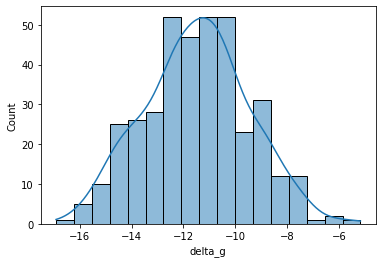

In [46]:
import seaborn as sns
sns.histplot(dataset, x="delta_g", kde=True)

<AxesSubplot:xlabel='delta_g', ylabel='Count'>

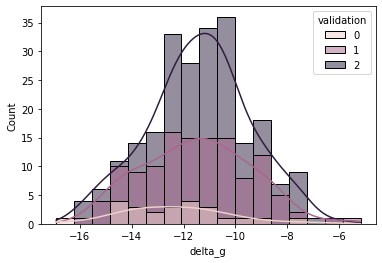

In [47]:
dataset.loc[dataset["validation"] == 3, "validation"] = 2 # only compare to validation set 1 for now
sns.histplot(dataset, x="delta_g", hue="validation", kde=True)

In [48]:
dataset["affinity"].describe()

count    3.800000e+02
mean     7.520152e-07
std      8.551151e-06
min      4.000000e-13
25%      4.275000e-10
50%      4.250000e-09
75%      3.100000e-08
max      1.600000e-04
Name: affinity, dtype: float64

## -log(Kg) Analyis

In [49]:
dataset["-log(Kd)"].describe()

count    380.000000
mean       8.418163
std        1.468840
min        3.795880
25%        7.508638
50%        8.371882
75%        9.369086
max       12.397940
Name: -log(Kd), dtype: float64

<AxesSubplot:xlabel='-log(Kd)', ylabel='Count'>

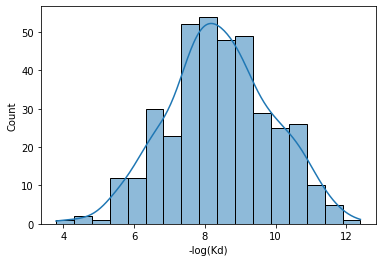

In [50]:
sns.histplot(dataset, x="-log(Kd)", kde=True)

<AxesSubplot:xlabel='-log(Kd)', ylabel='Count'>

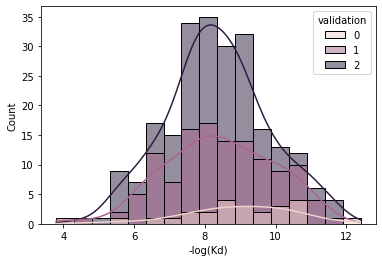

In [51]:
sns.histplot(dataset, x="-log(Kd)", hue="validation", kde=True)

In [52]:
#dataset['antibody_chains'] = dataset['antibody_chains'].fillna(dataset['sabdab_antibody_chains'])
#dataset['antigen_chains'] = dataset['antigen_chains'].fillna(dataset['sabdab_antigen_chains'])

In [53]:
dataset['antigen_chains'][0]

"['W']"

## Protein Analysis

### Antibody redudancy

In [90]:
from typing import List
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import seq1
from Bio.Seq import Seq 
from Bio import pairwise2

def get_sequence(filepath: str):
    structure = PDBParser(QUIET=True).get_structure('tmp', filepath)
    chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()}
            
    return chains

def is_redundant(filepath: str, chains: List, redudancy_cutoff: float = 0.8):
    orig_chains = get_sequence(os.path.join(config["PROJECT_ROOT"], filepath))
    for val_id, pdb_id, path in zip(val_ids, val_pdbs, pdb_paths):
        check_chains = get_sequence(os.path.join(config["PROJECT_ROOT"], 
                                                 "resources", "AbDb", "NR_LH_Protein_Martin", path))
        relevant_check_chains = dataset.loc[val_id, "antibody_chains"]
        
        for orig_chain, orig_seq in orig_chains.items():#
            if orig_chain not in chains:
                continue
            seq1 = Seq(orig_seq)
            for check_chain, check_seq in check_chains.items():
                if check_chain not in relevant_check_chains:
                    continue
                seq2 = Seq(check_seq)
                alignments = pairwise2.align.globalxx(seq1, seq2)
                for alignment in alignments:
                    score = alignment.score / (alignment.end - alignment.start)
                    if score > redudancy_cutoff:
                        return True, orig_chain, pdb_id, check_chain, score
    
    return False, None, None, None, None

In [91]:
dataset = dataset.reset_index(drop=True)
for i in range(len(dataset)):
    val_pdbs = dataset.loc[i + 1:,"pdb"].tolist()
    pdb_paths = dataset.loc[i + 1:,"filename"].tolist()
    val_ids = dataset.index[i + 1:].tolist()

    filepath = os.path.join(config["PROJECT_ROOT"], "resources", "AbDb", "NR_LH_Protein_Martin", dataset.loc[i, "filename"])

    chains = literal_eval(dataset.loc[i, "antibody_chains"])

    redundant, orig_chain, pdb_id, check_chain, score = is_redundant(filepath, chains)
    print(redundant)

True
True
False
True
True
True
True
True
True
False
True
False
True
True
True
True
True
False
False
True
True
True
True
False
False
True
True
True
True
True
True
True
True
False
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
False
False
True
True
True
True
True
True
False
True
True
False
False
False
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
True
False
False
True
True
False
True
True
False
False
False
False
True
True
True
False
True
True
False
False
T

In [62]:
dataset

,index,pdb,affinity,delta_g,affinity_method,temperature,abdb_filename,antibody_chains,antigen_chains,Hchain,...,sabdab_antibody_chains,sabdab_antigen_chains,calculated_temp,-log(Kd),filename,test,antigen_type,validation,chain_infos,data_location
0,0,1bj1,3.400000e-09,-11.550000,SPR,25,1BJ1_1.pdb,"['L', 'H']",['W'],H,...,"[H, L]",[W],25.0,8.468521,1BJ1_1.pdb,False,NaN,1,"{'l': 0, 'h': 0, 'w': 1}",RESOURCES
1,257,5dd0,8.370000e-08,-9.655130,Unknown,NaN,5DD0_1.pdb,"['L', 'H']",['P'],H,...,"[H, L]",[P],25.0,7.077275,5DD0_1.pdb,False,NaN,2,"{'l': 0, 'h': 0, 'p': 1}",RESOURCES
2,256,5d8j,1.780000e-09,-11.936563,SPR,NaN,5D8J_1.pdb,"['L', 'H']",['A'],H,...,"[H, L]",[A],25.0,8.749580,5D8J_1.pdb,False,NaN,2,"{'l': 0, 'h': 0, 'a': 1}",RESOURCES
3,255,5d72,6.000000e-12,-15.309341,Unknown,NaN,5D72_1.pdb,"['L', 'H']","['B', 'A']",M,...,"[M, N]",[B],25.0,11.221849,5D72_1.pdb,False,NaN,2,"{'l': 0, 'h': 0, 'b': 1, 'a': 1}",RESOURCES
4,254,5czx,6.000000e-10,-12.580853,SPR,NaN,5CZX_1.pdb,"['L', 'H']",['A'],H,...,"[H, L]",[A],25.0,9.221849,5CZX_1.pdb,False,NaN,2,"{'l': 0, 'h': 0, 'a': 1}",RESOURCES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,248,5c7x,4.000000e-13,-16.913816,Unknown,NaN,5C7X_1.pdb,"['L', 'H']","['B', 'A']",M,...,"[M, N]",[B],25.0,12.397940,5C7X_1.pdb,True,NaN,0,"{'l': 0, 'h': 0, 'b': 1, 'a': 1}",RESOURCES
376,337,6a0z,5.300000e-08,-9.925864,SPR,NaN,6A0Z_1.pdb,"['L', 'H']",['A'],H,...,"[H, L]",[A],25.0,7.275724,6A0Z_1.pdb,True,NaN,0,"{'l': 0, 'h': 0, 'a': 1}",RESOURCES
377,43,2fjg,2.000000e-08,-10.920000,SPR,37,2FJG_1.pdb,"['L', 'H']","['W', 'V']",H,...,"[H, L]",[W],37.0,7.698970,2FJG_1.pdb,True,NaN,0,"{'l': 0, 'h': 0, 'w': 1, 'v': 1}",RESOURCES
378,111,3l5w,5.400000e-11,-14.000000,SPR,25,3L5W_1.pdb,"['L', 'H']",['I'],B,...,"[B, A]",[J],25.0,10.267606,3L5W_1.pdb,True,NaN,0,"{'l': 0, 'h': 0, 'i': 1}",RESOURCES
